# Deep Matting - Inspect Trained Model (Portrait)

/home/tj/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor("div:0", shape=(400, 400, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from output/models/MnasUnet_Matting_final.ckpt


/home/tj/anaconda2/lib/python2.7/site-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/tj/anaconda2/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


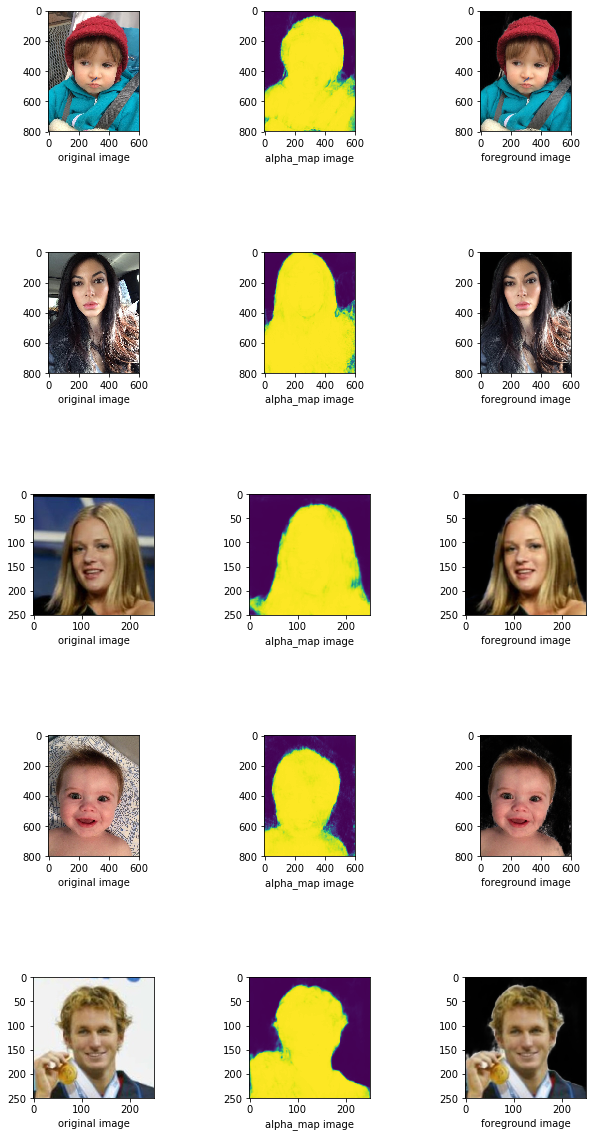

In [1]:
import os
import random
from timeit import default_timer as timer
import numpy as np
import scipy.misc as sm
import matplotlib.pyplot as plt

import tensorflow as tf
import libs.nets.MnasUnet as network
import libs.datasets.datapipe as datasets
import libs.configs.config as cfg

tf_image = tf.placeholder(dtype=tf.float32, shape=[None, None, 3], name='inputs')
norm_image = datasets._preprocess_for_test(tf_image)
norm_image = tf.expand_dims(norm_image, 0)

model = network.MnasUnet(norm_image, is_training=False)
pred_alpha = model.end_points['pred_alpha']
fg_seg = model.end_points['fg_seg']

""" set saver for saving final model and backbone model for restore """
saver = tf.train.Saver(max_to_keep=3)

""" Set Gpu Env """
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

saver = tf.train.Saver()
init_op = tf.global_variables_initializer()

# Performing post-processing on CPU: loop-intensive, usually more efficient.
with tf.Session() as sess:
    sess.run(init_op)
    ckpt_path = 'output/models/MnasUnet_Matting_final.ckpt'
    saver.restore(sess, ckpt_path)

    # ======================================================================
    images = os.listdir('data/test')
    ori_images = []
    alpha_imgs = []
    fg_imgs = []
    for fn in images:
        name = fn.split('.')[0]
        image = sm.imread('data/test/'+fn)

        feed_dict = {tf_image: image}
        result_alpha, result_fg = sess.run([pred_alpha, fg_seg], feed_dict=feed_dict)
        
        result_alpha = result_alpha[0][:, :, 0]
        result_fg = result_fg[0]

        h, w = image.shape[:2]
        alpha = sm.imresize(result_alpha, (h, w))
        fg = sm.imresize(result_fg, (h, w))
        
        ori_images.append(image)
        alpha_imgs.append(alpha)
        fg_imgs.append(fg)

    sess.close()

fig, axes = plt.subplots(len(ori_images), 3, figsize=(10, 20))
for i in range(len(axes)):
    axes[i, 0].imshow(ori_images[i])
    axes[i, 0].set_xlabel("original image")

    axes[i, 1].imshow(alpha_imgs[i])
    axes[i, 1].set_xlabel("alpha_map image")

    axes[i, 2].imshow(fg_imgs[i])
    axes[i, 2].set_xlabel("foreground image")

plt.subplots_adjust(left=0, wspace=0, hspace=1)
plt.show()

